In [2]:
import os
os.system("pip install ultralytics --quiet")
import shutil
import yaml
import random
import torch
import time
import subprocess
from ultralytics import YOLO
from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import defaultdict
import hashlib
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Sat Sep 27 19:33:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8       

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# --- Centralized Configuration for Easy Modification ---
# Project and Model Settings
model_name = 'yolo_mobilenetv3small_compleate_form'  # The YOLO model you want to train (e.g., 'yolo12m.pt')
dataset_name = 'SAM Mark rubber disease final datasetss Computer Vision Model'
random_state = 42

# Path Settings
# Make sure the dataset is correctly uploaded to Google Drive in the specified path
gdrive_dataset_path = '/content/drive/MyDrive/rubber-disease-final-datasetss-4-mark/'
extracted_path = '/content/temp_rubber-disease-final-datasetss-4-mark/'
output_kfold_dir = os.path.join(extracted_path, 'kfold_yolo')

# Data Split Ratios
test_split_ratio = 0.1  # 20% of the data for the final test set
val_split_ratio = 0.2  # 20% of the remaining data for the validation set, only used if val=True
num_folds = 1 # Number of folds for cross-validation

device = '0' if torch.cuda.is_available() else 'cpu'

# Train Settings
# การตั้งค่าพารามิเตอร์การฝึก
epochs = 100          # จำนวนรอบการฝึก (epochs) default=100
batch = 16            # ขนาดของชุดข้อมูล (batch size) default=16
imgsz = 640           # ขนาดของภาพ (image size) default=640
optimizer = 'AdamW'   # ออปติไมเซอร์ที่ใช้ในการฝึก 'AdamW' default='auto'
lr0 = 0.01            # อัตราการเรียนรู้เริ่มต้น (initial learning rate) default=0.01
lrf = 0.01            # อัตราการเรียนรู้สุดท้าย (final learning rate) default=0.01
momentum = 0.937      # โมเมนตัมสำหรับ SGD/AdamW default=0.937
box = 7.5             # ค่า loss weight สำหรับ box default=7.5
cls = 0.5             # ค่า loss weight สำหรับ classification default=0.5
dfl = 1.5             # ค่า loss weight สำหรับ dfl default=1.5
dropout = 0.0         # อัตราการ Dropout (ตั้งแต่ 0.0 ถึง 1.0) default=0.0
patience = 100        # จำนวน epochs ที่จะรอการปรับปรุง default=100
cache = 'ram'         # ใช้ caching สำหรับข้อมูลหรือไม่ default=False
time = None            # เวลาสูงสุดที่ใช้ในการฝึก (เป็นชั่วโมง) default=None

if num_folds > 1:
    # ถ้า num_folds มากกว่า 1 หมายความว่าเราจะทำ K-fold
    # ซึ่งในกระบวนการ K-fold จะมีการแบ่ง validation set ในแต่ละ fold อยู่แล้ว
    # จึงไม่จำเป็นต้องสร้าง validation set แยกต่างหากอีก
    val = False
    print(f"โหมดการทำงาน: {num_folds}-fold cross-validation")
    print("จะไม่สร้าง validation set แยกต่างหาก (val = False)")
else:
    # ถ้า num_folds เท่ากับ 1 หมายความว่าเราต้องการเทรนแบบปกติ
    # คือการแบ่งข้อมูลเป็น training set และ validation set เพียงครั้งเดียว
    val = True
    print("โหมดการทำงาน: Single train/validation split")
    print("จะสร้าง validation set แยกต่างหาก (val = True)")

โหมดการทำงาน: Single train/validation split
จะสร้าง validation set แยกต่างหาก (val = True)


In [7]:
# --- Helper Functions ---
def get_image_class_labels(labels_dir):
    """
    Reads label files to determine the primary class for each image.
    This is used for stratification to ensure a balanced split.
    If an image has multiple classes, it picks the first one.
    """
    image_labels = {}
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory not found at {labels_dir}")
        return image_labels

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            image_id = os.path.splitext(label_file)[0]
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()
                if lines:
                    # Pick the first class found in the label file for stratification
                    try:
                        class_id = int(lines[0].split()[0])
                        image_labels[image_id] = class_id
                    except (ValueError, IndexError):
                        # Handle malformed lines
                        image_labels[image_id] = -1
                else:
                    # Handle case with an empty label file
                    image_labels[image_id] = -1 # A placeholder for images with no objects
    return image_labels

def verify_and_count_data(data_dir, class_names):
    """
    Verifies the integrity of the split by counting images, labels, and bounding boxes.
    """
    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    # Check if directories exist
    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"  [ERROR] Directory not found: {data_dir}")
        return

    num_images = len(os.listdir(images_dir))
    num_labels = len(os.listdir(labels_dir))

    bbox_counts = defaultdict(int)
    total_bbox_count = 0

    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.split()[0])
                        bbox_counts[class_id] += 1
                        total_bbox_count += 1
                    except (IndexError, ValueError):
                        # Skip malformed lines
                        continue

    print(f"  Number of images: {num_images}")
    print(f"  Number of labels: {num_labels}")
    print("  Bounding box counts per class:")
    for class_id, count in sorted(bbox_counts.items()):
        if class_id < len(class_names):
            print(f"    - Class {class_id} ({class_names[class_id]}): {count}")
        else:
            print(f"    - Class {class_id}: {count}")
    print(f"  Total number of bounding boxes: {total_bbox_count}")

def calculate_dir_hash(directory):
    """Calculates a consistent hash of a directory's contents."""
    hasher = hashlib.sha256()
    if not os.path.exists(directory):
        return None
    for root, _, files in os.walk(directory):
        for file in sorted(files):
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                while chunk := f.read(8192):
                    hasher.update(chunk)
    return hasher.hexdigest()

def verify_original_dataset(data_dir, class_names):
    """
    Counts images, labels, and bounding boxes in the original dataset root.
    """
    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    if not os.path.exists(images_dir) or not os.path.exists(labels_dir):
        print(f"Error: 'images' or 'labels' directory not found in the original dataset root.")
        return

    num_images = len(os.listdir(images_dir))
    num_labels = len(os.listdir(labels_dir))

    bbox_counts = defaultdict(int)
    total_bbox_count = 0

    # Count bounding boxes and classes
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                for line in f:
                    try:
                        class_id = int(line.split()[0])
                        bbox_counts[class_id] += 1
                        total_bbox_count += 1
                    except (IndexError, ValueError):
                        continue

    print(f"Number of images in {images_dir}: {num_images}")
    print(f"Number of labels in {labels_dir}: {num_labels}")

    print("Bounding box counts per class (Original Dataset):")
    for class_id, count in sorted(bbox_counts.items()):
        if class_id < len(class_names):
            print(f"  - Class {class_id} ({class_names[class_id]}): {count}")
        else:
            print(f"  - Class {class_id}: {count}")
    print(f"Total number of bounding boxes (Original Dataset): {total_bbox_count}")

In [8]:
# =================================================================
# --- 1. Data Ingestion (การนำเข้าข้อมูล) ---
# This part is responsible for copying and preparing the dataset.
# =================================================================

# Ensure the destination directory exists and is clean
if os.path.exists(extracted_path):
    shutil.rmtree(extracted_path)
os.makedirs(extracted_path, exist_ok=True)

# Copy the dataset from Google Drive
print(f"Copying {gdrive_dataset_path} to {extracted_path}...")
try:
    shutil.copytree(gdrive_dataset_path, extracted_path, dirs_exist_ok=True)
except FileNotFoundError:
    print(f"Error: Dataset not found at {gdrive_dataset_path}. Please check the path and try again.")
    exit()

# --- Find the zip file and unpack it using shutil ---
zip_file_path = None
for root, _, files in os.walk(extracted_path):
    for f in files:
        if f.endswith('.zip'):
            zip_file_path = os.path.join(root, f)
            break
    if zip_file_path:
        break

if zip_file_path:
    print(f"Successfully unpacked {zip_file_path} to {extracted_path}")
    try:
        shutil.unpack_archive(zip_file_path, extracted_path)
    except shutil.ReadError:
        print(f"Error: The file at {zip_file_path} is not a valid archive file that can be unpacked by shutil.")
        exit()
else:
    print("Warning: No zip file found in the copied directory. Assuming the data is already extracted.")

# --- Automatically find the correct dataset root directory ---
images_path, labels_path, data_yaml_path = None, None, None
dataset_root = None
for root, dirs, files in os.walk(extracted_path):
    if 'images' in dirs and 'labels' in dirs and 'data.yaml' in files:
        dataset_root = root
        images_path = os.path.join(dataset_root, 'images')
        labels_path = os.path.join(dataset_root, 'labels')
        data_yaml_path = os.path.join(dataset_root, 'data.yaml')
        break

if not images_path or not labels_path or not data_yaml_path:
    print("Error: Could not find the 'images', 'labels' directories and 'data.yaml' file within the extracted path.")
    exit()

# Load the data.yaml to get class information
try:
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    num_classes = data['nc']
    class_names = data['names']

    print(f"\nNumber of classes: {num_classes}")
    print(f"Class names: {class_names}")
except FileNotFoundError:
    print(f"Error: data.yaml not found at {data_yaml_path}. Please check your dataset structure.")
    exit()

# --- NEW: Verify and count the original dataset contents ---
verify_original_dataset(dataset_root, class_names)
print(f"Original dataset root hash: {calculate_dir_hash(dataset_root)}")


# Get all image file names
all_image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
all_image_ids = [os.path.splitext(f)[0] for f in all_image_files]

# Get a stratified list of labels for each image for splitting
image_labels_map = get_image_class_labels(labels_path)
stratify_labels = [image_labels_map.get(img_id, -1) for img_id in all_image_ids]

Copying /content/drive/MyDrive/rubber-disease-final-datasetss-4-mark/ to /content/temp_rubber-disease-final-datasetss-4-mark/...
Successfully unpacked /content/temp_rubber-disease-final-datasetss-4-mark/rubber-disease-final-datasetss-4-mark.zip to /content/temp_rubber-disease-final-datasetss-4-mark/

Number of classes: 3
Class names: ['Colletotrichum', 'Corynespora', 'Leaf-Blight']
Number of images in /content/temp_rubber-disease-final-datasetss-4-mark/images: 2684
Number of labels in /content/temp_rubber-disease-final-datasetss-4-mark/labels: 2684
Bounding box counts per class (Original Dataset):
  - Class 0 (Colletotrichum): 7436
  - Class 1 (Corynespora): 5139
  - Class 2 (Leaf-Blight): 3610
Total number of bounding boxes (Original Dataset): 16185
Original dataset root hash: 47b5739097e4c3745d176b71bff09288e485cd012eec4416d56c547e79fc545b


In [9]:
# =================================================================
# --- 2. Data Splitting (การแบ่งข้อมูล) ---
# This part handles the main logic for single split vs k-fold.
# =================================================================

base_kfold_path = os.path.join(extracted_path, 'kfold_yolo')
if os.path.exists(base_kfold_path):
    shutil.rmtree(base_kfold_path)
os.makedirs(base_kfold_path, exist_ok=True)

# Main logic to handle single split vs k-fold
if num_folds > 1:
    if num_folds < 2:
        raise ValueError("K-fold cross-validation requires n_splits=2 or more.")
    print(f"\nRunning K-Fold Cross-Validation with {num_folds} folds.")
    # Step 1: Separate a fixed portion for the final Test Set
    train_val_ids, test_ids, _, _ = train_test_split(
        all_image_ids,
        stratify_labels,
        test_size=test_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=stratify_labels
    )

    # Step 2: Use Stratified K-Fold on the remaining data
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    train_val_labels = [image_labels_map.get(img_id, -1) for img_id in train_val_ids]
    fold_splits = skf.split(train_val_ids, train_val_labels)

else:
    print("\nRunning a single train/validation/test split.")
    # Step 1: Separate a fixed portion for the final Test Set
    train_val_ids, test_ids, _, _ = train_test_split(
        all_image_ids,
        stratify_labels,
        test_size=test_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=stratify_labels
    )

    # Step 2: Split the remaining data into Train and Validation sets
    train_ids, val_ids, _, _ = train_test_split(
        train_val_ids,
        [image_labels_map.get(img_id, -1) for img_id in train_val_ids],
        test_size=val_split_ratio,
        random_state=random_state,
        shuffle=True,
        stratify=[image_labels_map.get(img_id, -1) for img_id in train_val_ids]
    )

    # Create a dummy fold split iterable to reuse the loop below
    fold_splits = [(list(range(len(train_ids))), list(range(len(val_ids))))]
    num_folds = 1

# Loop through the determined splits
for i, (train_index, val_index) in enumerate(fold_splits):
    fold_num = i + 1
    print(f"\n---------------------- Processing Fold {fold_num} ----------------------")

    # Adjust image IDs based on single split vs k-fold
    if num_folds > 1:
        fold_train_ids = [train_val_ids[idx] for idx in train_index]
        fold_val_ids = [train_val_ids[idx] for idx in val_index]
    else:
        fold_train_ids = train_ids
        fold_val_ids = val_ids

    # If val is False, add validation data to the training set.
    if not val:
        print("Note: 'val' is set to False. The validation data for this fold will be added to the training set.")
        fold_train_ids.extend(fold_val_ids)
        fold_val_ids = []

    # Verify the split ratios for this fold
    total_images_in_dataset = len(all_image_files)
    print(f"Total images in dataset: {total_images_in_dataset}")
    print(f"Train images: {len(fold_train_ids)} ({len(fold_train_ids)/total_images_in_dataset:.2%})")

    if val:
        print(f"Validation images: {len(fold_val_ids)} ({len(fold_val_ids)/total_images_in_dataset:.2%})")
    print(f"Test images: {len(test_ids)} ({len(test_ids)/total_images_in_dataset:.2%})")

    # Create output directories for the current fold
    fold_dir = os.path.join(output_kfold_dir, f'fold{fold_num}')
    if os.path.exists(fold_dir):
        shutil.rmtree(fold_dir)

    os.makedirs(os.path.join(fold_dir, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'train', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'test', 'images'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'test', 'labels'), exist_ok=True)
    if val:
        os.makedirs(os.path.join(fold_dir, 'val', 'images'), exist_ok=True)
        os.makedirs(os.path.join(fold_dir, 'val', 'labels'), exist_ok=True)

    # --- Copy files to the respective directories with progress bar ---
    print("\nCopying files...")

    # Copy Test set
    for img_id in tqdm(test_ids, desc="Copying Test files"):
        if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
            shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'test', 'images'))
        if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
            shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'test', 'labels'))

    # Copy Training set
    for img_id in tqdm(fold_train_ids, desc="Copying Train files"):
        if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
            shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'train', 'images'))
        if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
            shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'train', 'labels'))

    # Copy Validation set
    if val and len(fold_val_ids) > 0:
        for img_id in tqdm(fold_val_ids, desc="Copying Validation files"):
            if os.path.exists(os.path.join(images_path, f'{img_id}.jpg')):
                shutil.copy(os.path.join(images_path, f'{img_id}.jpg'), os.path.join(fold_dir, 'val', 'images'))
            if os.path.exists(os.path.join(labels_path, f'{img_id}.txt')):
                shutil.copy(os.path.join(labels_path, f'{img_id}.txt'), os.path.join(fold_dir, 'val', 'labels'))

    # --- Create the YAML file for the current fold ---
    print("\nCreating YAML file...")
    yaml_content = {
        'path': fold_dir,
        'train': 'train/images',
        'test': 'test/images',
        'nc': num_classes,
        'names': class_names
    }

    if val:
        yaml_content['val'] = 'val/images'
    else:
        yaml_content['val'] = 'train/images'

    yaml_path = os.path.join(fold_dir, f'fold{fold_num}_data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)
    print(f"Created YAML file at: {yaml_path}")

    # --- Verify the contents of the new folders ---
    print("\nVerifying data counts and hash in each split:")
    print("  [TRAIN SET]")
    verify_and_count_data(os.path.join(fold_dir, 'train'), class_names)
    print(f"  Train set hash: {calculate_dir_hash(os.path.join(fold_dir, 'train'))}")
    if val:
        print("  [VALIDATION SET]")
        verify_and_count_data(os.path.join(fold_dir, 'val'), class_names)
        print(f"  Validation set hash: {calculate_dir_hash(os.path.join(fold_dir, 'val'))}")
    print("  [TEST SET]")
    verify_and_count_data(os.path.join(fold_dir, 'test'), class_names)
    print(f"  Test set hash: {calculate_dir_hash(os.path.join(fold_dir, 'test'))}")

print("\nAll folds have been created and verified!")
print(f"Final K-Fold directory hash: {calculate_dir_hash(output_kfold_dir)}")


Running a single train/validation/test split.

---------------------- Processing Fold 1 ----------------------
Total images in dataset: 2684
Train images: 1932 (71.98%)
Validation images: 483 (18.00%)
Test images: 269 (10.02%)

Copying files...


Copying Validation files: 100%|██████████| 483/483 [00:00<00:00, 3299.93it/s]



Creating YAML file...
Created YAML file at: /content/temp_rubber-disease-final-datasetss-4-mark/kfold_yolo/fold1/fold1_data.yaml

Verifying data counts and hash in each split:
  [TRAIN SET]
  Number of images: 1932
  Number of labels: 1932
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 5340
    - Class 1 (Corynespora): 3672
    - Class 2 (Leaf-Blight): 2545
  Total number of bounding boxes: 11557
  Train set hash: 58372904ce2083bdd203e194843f94f280141c7c3bd199253349ebdf93f508bf
  [VALIDATION SET]
  Number of images: 483
  Number of labels: 483
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 1220
    - Class 1 (Corynespora): 928
    - Class 2 (Leaf-Blight): 689
  Total number of bounding boxes: 2837
  Validation set hash: fc6f50fc0fd47280c36c7235a54e2a9e24f1ad03de2cad69d9ee1b493fc10953
  [TEST SET]
  Number of images: 269
  Number of labels: 269
  Bounding box counts per class:
    - Class 0 (Colletotrichum): 876
    - Class 1 (Corynespora): 539
    -

In [10]:
# The code below will iterate through each created fold and train a YOLO model.
model = YOLO(f'{model_name}.pt')

# Calculate time per fold if a total time is specified
time_per_fold = None
if time is not None and isinstance(time, (int, float)):
    time_per_fold = time / num_folds
    print(f"Total training time per fold has been set to {time_per_fold:.2f} hours.")

for i in range(num_folds):
    fold_num = i + 1
    print(f"\n======================== Training Fold {fold_num}/{num_folds} ========================")

    # Path to the YAML file for the current fold
    fold_data_yaml = os.path.join(output_kfold_dir, f'fold{fold_num}', f'fold{fold_num}_data.yaml')

    # Determine the patience value for this specific training run
    # If val is False, set patience to the default value of 100.
    patience_to_use = patience if val else 100

    # Train the model for the current fold
    # The `data` argument specifies the path to the YAML file.
    # The `epochs` and `imgsz` can be adjusted based on your needs.
    model.train(
        data=fold_data_yaml,
        epochs=epochs,
        batch=batch,
        imgsz=imgsz,
        optimizer=optimizer,
        lr0=lr0,
        lrf=lrf,
        momentum=momentum,
        box=box,
        cls=cls,
        dfl=dfl,
        dropout=dropout,
        patience=patience_to_use,
        cache=cache,
        device=device,
        val=val,
        seed=random_state,
        name=f'{model_name}_fold{fold_num}',
        plots=True,
        exist_ok=True,
        time=time_per_fold
    )
print("\n======================== K-Fold Training Complete ========================")
source_dir = '/content/runs'
destination_dir_name = f'{model_name}_{dataset_name}'
destination_path = os.path.join('/content/drive/MyDrive/', destination_dir_name)
if os.path.exists(source_dir):
    print(f"Copying '{source_dir}' to '{destination_path}'...")
    shutil.copytree(source_dir, destination_path, dirs_exist_ok=True)
    print("Copying complete.")
else:
    print(f"Source directory '{source_dir}' does not exist.")


======================== Training Fold 1/1 ========================
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/temp_rubber-disease-final-datasetss-4-mark/kfold_yolo/fold1/fold1_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_mobilenetv3small_compleate_form.pt, momentum=0.937, mosaic=1.0, multi_scale=F


===== Processing Fold 1/1 =====


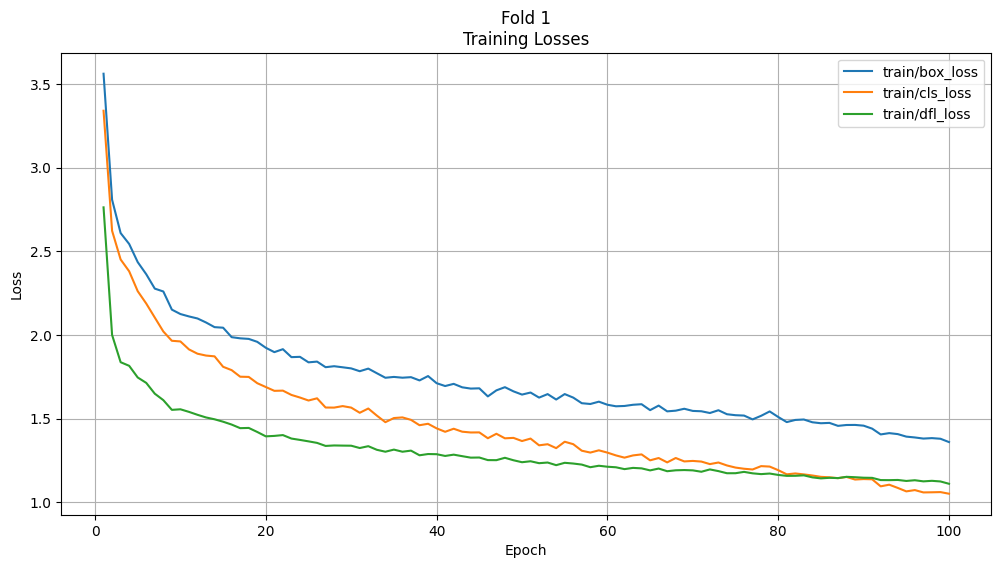

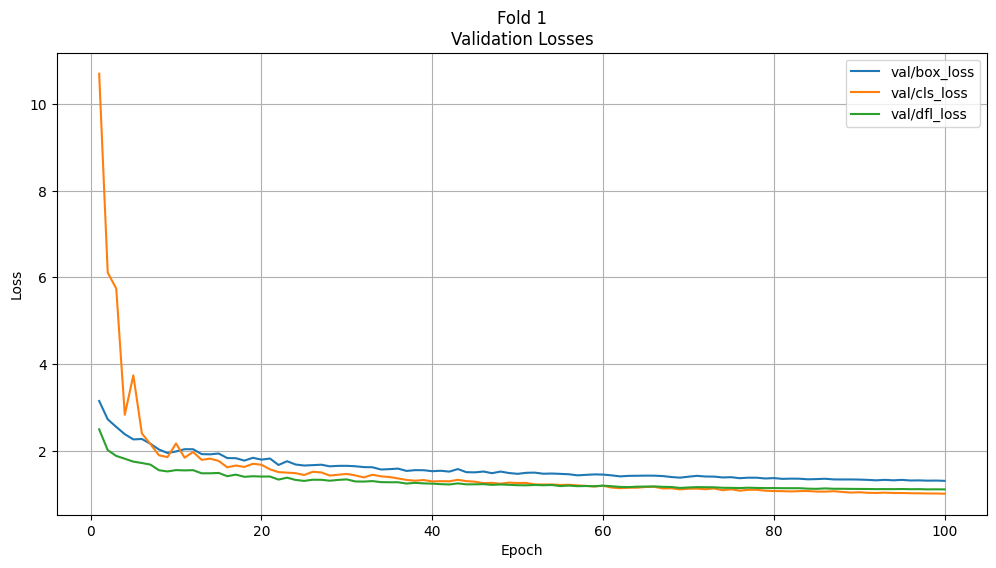

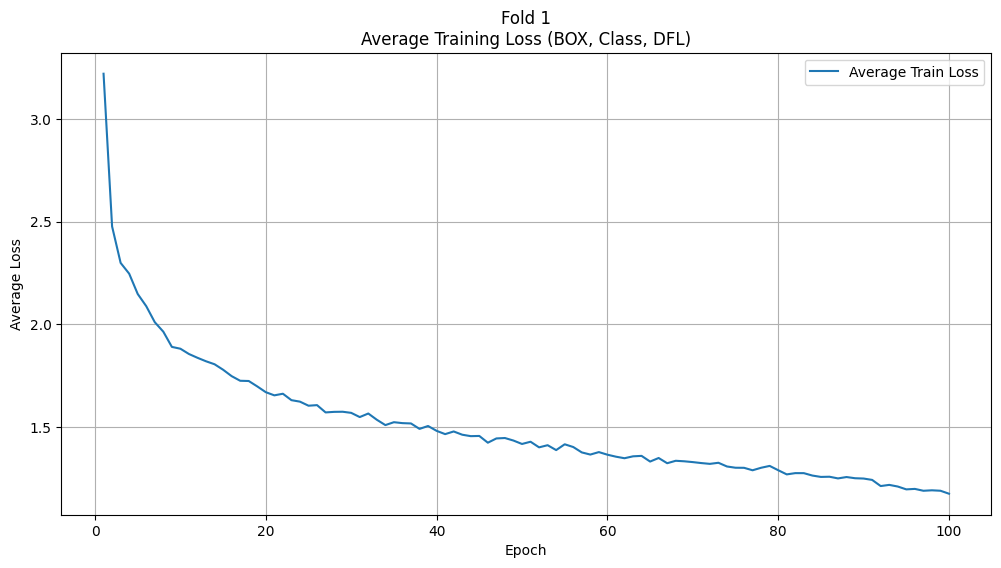

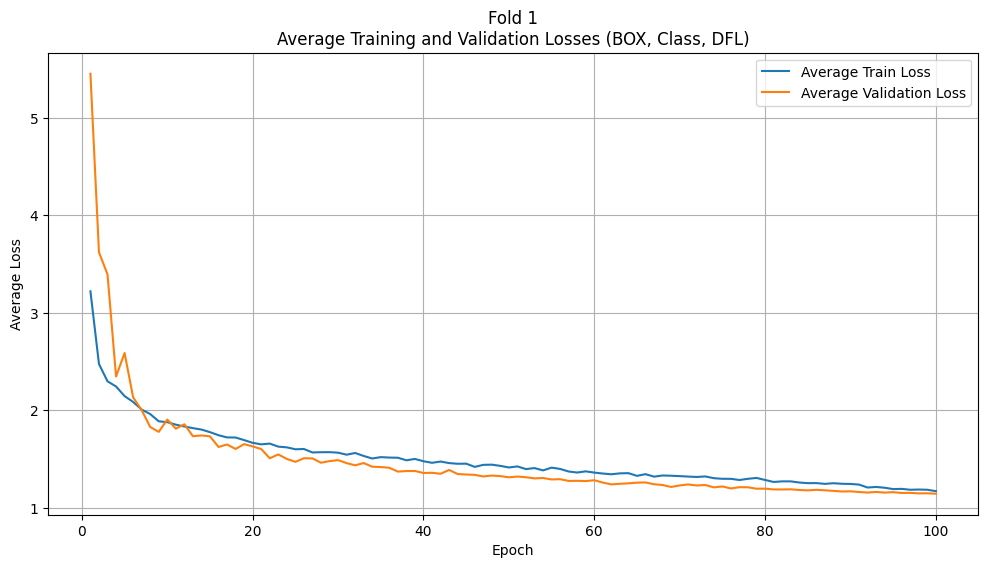

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# --- การตั้งค่าที่ควรจะถูกกำหนดค่ามาก่อน ---
# model_name = 'your_model_name' # ชื่่อโมเดล
# num_folds = 5 # จำนวน fold ทั้งหมดที่ตั้งค่าไว้
# -----------------------------------------------------------------

# --- ตรรกะในการกำหนดค่า val อัตโนมัติ ---
if num_folds > 1:
    val = False
else:
    val = True
# -----------------------------------------------------------------

# --- สร้าง List ว่างสำหรับเก็บผลลัพธ์ของแต่ละ Fold ---
# ตัวแปรนี้จะใช้เก็บข้อมูล train lossเฉลี่ยของแต่ละ fold เพื่อนำไปสร้างกราฟที่ 5
all_folds_avg_losses = []
# -----------------------------------------------------------------


# --- เริ่ม Loop สำหรับแต่ละ Fold ---
# โค้ดส่วนนี้จะวนทำงานตามจำนวน fold ที่คุณกำหนด
for fold_num in range(1, num_folds + 1):
    print(f"\n===== Processing Fold {fold_num}/{num_folds} =====")
    # กำหนด Path ไปยังไฟล์ results.csv ของแต่ละ fold
    if num_folds > 1:
        results_csv_path = os.path.join('/content/runs/detect', f'{model_name}_fold{fold_num}', 'results.csv')
    else:
        results_csv_path = os.path.join('/content/runs/detect', f'{model_name}_fold1', 'results.csv')

    if not os.path.exists(results_csv_path):
        print(f"Error: {results_csv_path} not found. Skipping this fold.")
        continue # ข้ามไปทำงาน fold ต่อไปถ้าไม่พบไฟล์

    # อ่านและประมวลผลไฟล์ results.csv
    results_df = pd.read_csv(results_csv_path)
    results_df.columns = results_df.columns.str.strip()
    results_df['epoch'] = pd.to_numeric(results_df['epoch'])
    results_df_filtered = results_df[(results_df['epoch'] >= 1) & (results_df['epoch'] <= 100)].copy()

    # ---------------------------------------------------------
    # กราฟที่ 1-4: พล็อตผลลัพธ์สำหรับแต่ละ Fold (เหมือนเดิม)
    # ---------------------------------------------------------

    # กราฟที่ 1: Training Losses
    plt.figure(figsize=(12, 6))
    plt.plot(results_df_filtered['epoch'], results_df_filtered['train/box_loss'], label='train/box_loss')
    plt.plot(results_df_filtered['epoch'], results_df_filtered['train/cls_loss'], label='train/cls_loss')
    plt.plot(results_df_filtered['epoch'], results_df_filtered['train/dfl_loss'], label='train/dfl_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_num}\nTraining Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

    # กราฟที่ 2: Validation Losses (ถ้า val=True)
    if val:
        plt.figure(figsize=(12, 6))
        plt.plot(results_df_filtered['epoch'], results_df_filtered['val/box_loss'], label='val/box_loss')
        plt.plot(results_df_filtered['epoch'], results_df_filtered['val/cls_loss'], label='val/cls_loss')
        plt.plot(results_df_filtered['epoch'], results_df_filtered['val/dfl_loss'], label='val/dfl_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold_num}\nValidation Losses')
        plt.legend()
        plt.grid(True)
        plt.show()

    # คำนวณ Average Training Loss สำหรับ fold ปัจจุบัน
    results_df_filtered['train_avg_loss'] = results_df_filtered[['train/box_loss', 'train/cls_loss', 'train/dfl_loss']].mean(axis=1)

    # กราฟที่ 3: Average Training Loss
    plt.figure(figsize=(12, 6))
    plt.plot(results_df_filtered['epoch'], results_df_filtered['train_avg_loss'], label='Average Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title(f'Fold {fold_num}\nAverage Training Loss (BOX, Class, DFL)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # กราฟที่ 4: Average Training and Validation Losses
    plt.figure(figsize=(12, 6))
    plt.plot(results_df_filtered['epoch'], results_df_filtered['train_avg_loss'], label='Average Train Loss')
    if val:
        results_df_filtered['val_avg_loss'] = results_df_filtered[['val/box_loss', 'val/cls_loss', 'val/dfl_loss']].mean(axis=1)
        plt.plot(results_df_filtered['epoch'], results_df_filtered['val_avg_loss'], label='Average Validation Loss')
        plt.title(f'Fold {fold_num}\nAverage Training and Validation Losses (BOX, Class, DFL)')
    else:
        plt.title(f'Fold {fold_num}\nAverage Training Loss (BOX, Class, DFL)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- เก็บข้อมูลสำหรับกราฟที่ 5 ---
    if num_folds > 1:
        # ตั้งค่า epoch เป็น index เพื่อให้ง่ายต่อการคำนวณค่าเฉลี่ยทีหลัง
        avg_loss_series = results_df_filtered.set_index('epoch')['train_avg_loss']
        all_folds_avg_losses.append(avg_loss_series)

# --- สิ้นสุด Loop ---


# ---------------------------------------------------------
# กราฟที่ 5: ค่าเฉลี่ยของ Train Loss ตลอดทุก Fold
# โค้ดส่วนนี้จะทำงานหลังจากที่ Loop ด้านบนทำงานเสร็จสิ้นครบทุก Fold แล้ว
# ---------------------------------------------------------
if num_folds > 1 and all_folds_avg_losses:
    print("\n===== Plotting Overall Average Across All Folds =====")
    # นำข้อมูล Series ของแต่ละ fold มารวมกันเป็น DataFrame เดียว
    # โดยแต่ละคอลัมน์คือผลลัพธ์ของแต่ละ fold
    combined_losses_df = pd.concat(all_folds_avg_losses, axis=1)

    # คำนวณค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐาน (Standard Deviation) ตลอดทุก Fold
    mean_loss = combined_losses_df.mean(axis=1)
    std_loss = combined_losses_df.std(axis=1)

    # เริ่มพล็อตกราฟ
    plt.figure(figsize=(12, 6))
    plt.plot(mean_loss.index, mean_loss, label='Average Train Loss Across Folds', color='blue')

    # เพิ่มพื้นที่แรเงาเพื่อแสดงค่าเบี่ยงเบนมาตรฐาน
    plt.fill_between(mean_loss.index, mean_loss - std_loss, mean_loss + std_loss, color='blue', alpha=0.2, label='Standard Deviation')

    plt.title(f'Average Training Loss Across All {num_folds} Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True)
    plt.show()